# Одномерная минимизация криловлинейной psf.
* поиск дальней точки через кепстр
* начальное приближение - полный перебор на срединном перпендикуляре
* уточнение одним из (стандартных) алгоритмов
<img src="pic/minimization_ill.png">

Время работы: 2:24

In [1]:
import numpy as np
from skimage import color, data, restoration, img_as_float, io
from scipy.signal import convolve2d as conv2

from skimage.restoration import richardson_lucy
from skimage.measure import compare_psnr
from functools import partial
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult
from tqdm import tqdm_notebook

from util import *
from richardson_lucy import *

In [2]:
astro = color.rgb2gray(data.astronaut())
liftingbody = img_as_float(io.imread('liftingbody.png'))
iterations = 30

In [3]:
psf_drawn = img_as_float(io.imread("input/drawn-psf4.bmp"))
if len(psf_drawn.shape) == 3:
    psf_drawn = psf_drawn[:,:,0]
psf_drawn /= np.sum(psf_drawn)

In [4]:
lifting_drawn_blurred = convolve2d(liftingbody, psf_drawn, 'same')

deconv_orig = richardson_lucy_matlab(lifting_drawn_blurred, psf_drawn, iterations=iterations, 
                                     useFFT=True)#dampar=s_n, 
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

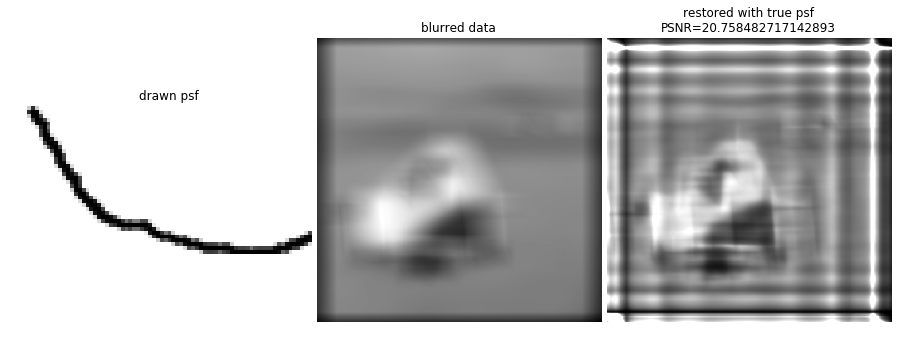

In [5]:
show_results(psf_drawn, lifting_drawn_blurred, deconv_orig['image'],
            titles=['drawn psf', 'blurred data', 'restored with true psf\nPSNR={0}'.format(psnr_orig)])

In [6]:
s_n, S_find = find_noise(lifting_drawn_blurred)
s_n

2.2596400237837347e-05

In [7]:
N,M = lifting_drawn_blurred.shape
# ( ifft2 (100* log (1+ abs ( fft2 ( I ) ) ) ) ) ;
K = np.fft.ifftn(100*np.log(1+np.abs(np.fft.fftn(lifting_drawn_blurred))))
K_shift = np.fft.fftshift(K)

n, m, = K_shift.shape

K_shift[:, m//2] = 1
K_shift[n//2, :] = 1
K_shift[n//2-3:n//2+4, m//2-3:m//2+4] = 1

c,r = np.unravel_index(np.argmin(np.real(K_shift), axis=None), K_shift.shape)
print(c,r)
x0_2 = np.array([r - n//2, c - m//2])

if x0_2[0]<0:
    x0_2 = -x0_2
x0_1 = x0_2/2# + np.array([4,-4])
x0 = np.concatenate((x0_1, x0_2))
print(x0)

260 183
[36.5 -2.  73.  -4. ]


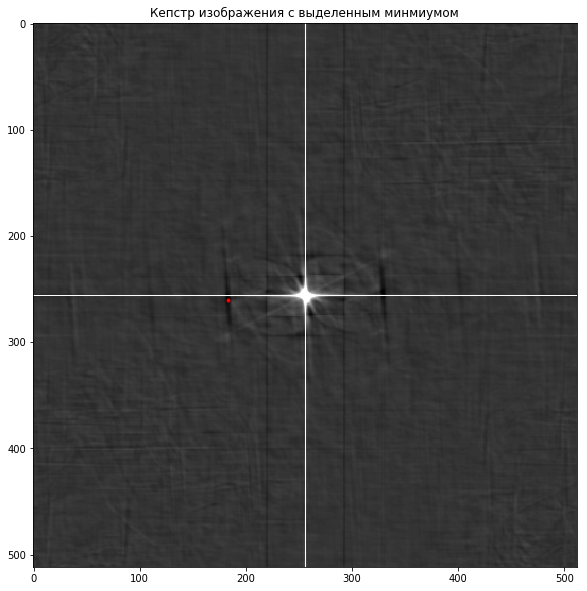

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(np.real(K_shift), -1, 1), 'gray')#, vmin=noisy.min(), vmax=noisy.max())
#plt.plot(n//2 + x0_2[1], m//2 + x0_2[0], 'r.')
plt.plot(r, c, 'r.')
plt.title('Кепстр изображения с выделенным минмиумом')
plt.show()

In [9]:
K_shift[r,c]

(-0.025840005576983648+1.0066523709132109e-15j)

In [11]:
def second_point(x2, dist=0):
    n = np.array([x2[1], -x2[0]])
    n_len = vec_len(n)
    if n_len<1e-16:
        n = 1e-16
    else:
        n = n/vec_len(n)
    mid = x2 / 2
    return mid + n*dist

In [12]:
x1_vec = np.array([x0_2[1], -x0_2[0]])
x1_vec = x1_vec / vec_len(x1_vec)
print(x1_vec)

[-0.05471245 -0.99850215]


In [13]:
def funcToMinimizeCurved2(xy, I_blurred, xy2, crop=100, *args, **kwargs):
    psf = bezier_psf2(np.concatenate((np.array(xy), np.array(xy2))), n=100)
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = convolve2d(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))

In [14]:
def funcToMinimizeCurvedNormal(dist, I_blurred, xy2, crop=100, *args, **kwargs):
    xy = second_point(xy2, dist)
    print(dist, xy)
    
    psf = bezier_psf2(np.concatenate((np.array(xy), np.array(xy2))), n=100)
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = convolve2d(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))

In [15]:
cost_fun = partial(funcToMinimizeCurvedNormal, I_blurred=lifting_drawn_blurred, xy2=x0_2, 
                   iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True)

In [16]:
L = vec_len(x0_2)

In [17]:
distances = np.linspace(-L/2, L/2, 30)
best_val = 1e9 #+inf
best_dist = 0
for dist in distances:
    val = cost_fun(dist)
    if val < best_val:
        best_dist = dist
        best_val = val

-36.55475345286848 [38.5 34.5]
-34.03373597336031 [38.36206897 31.98275862]
-31.51271849385214 [38.22413793 29.46551724]
-28.991701014343967 [38.0862069  26.94827586]
-26.4706835348358 [37.94827586 24.43103448]
-23.949666055327626 [37.81034483 21.9137931 ]
-21.428648575819455 [37.67241379 19.39655172]
-18.907631096311285 [37.53448276 16.87931034]
-16.386613616803114 [37.39655172 14.36206897]
-13.865596137294943 [37.25862069 11.84482759]
-11.344578657786773 [37.12068966  9.32758621]
-8.823561178278602 [36.98275862  6.81034483]
-6.302543698770428 [36.84482759  4.29310345]
-3.781526219262261 [36.70689655  1.77586207]
-1.260508739754087 [36.56896552 -0.74137931]
1.26050873975408 [36.43103448 -3.25862069]
3.781526219262254 [36.29310345 -5.77586207]
6.302543698770428 [36.15517241 -8.29310345]
8.823561178278595 [ 36.01724138 -10.81034483]
11.34457865778677 [ 35.87931034 -13.32758621]
13.865596137294936 [ 35.74137931 -15.84482759]
16.38661361680311 [ 35.60344828 -18.36206897]
18.90763109631127

In [18]:
best_dist, best_val

(-6.302543698770428, 7.049147526621112e-06)

In [19]:
point2 = second_point(x0_2, best_dist)
points_found = np.concatenate((point2, x0_2))
print(points_found)

[36.84482759  4.29310345 73.         -4.        ]


In [20]:
deconv_orig = richardson_lucy_matlab(lifting_drawn_blurred, psf_drawn, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = drawn_psf2(x0)
deconv_init = richardson_lucy_matlab(lifting_drawn_blurred, psf_init, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

#points_found = res_my_grad2['x']
psf_found = drawn_psf2(points_found)
deconv_found = richardson_lucy_matlab(lifting_drawn_blurred, psf_found, iterations=iterations, 
                                      dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig.round(2), points_real), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), x0.round(4)),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), points_found.round(4))],
             savefig='pic/one-dim.png')

NameError: name 'drawn_psf2' is not defined

In [ ]:
def funcToMinimizeCurved(xy, I_blurred, crop=100, *args, **kwargs):
    psf = drawn_psf2(xy, n=100)
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = convolve2d(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))

In [ ]:
res_nelder = minimize(partial(funcToMinimizeCurved, I_blurred=lifting_drawn_blurred, 
                              iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True),
                      x0=points_found, method='Nelder-Mead', options={'xatol': 1e-4, 'disp': True})
print(res_nelder)

In [ ]:
deconv_orig = richardson_lucy_matlab(lifting_drawn_blurred, psf_drawn, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = drawn_psf2(points_found)
deconv_init = richardson_lucy_matlab(lifting_drawn_blurred, psf_init, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

#points_found = res_my_grad2['x']
points_found2 = res_nelder.x
psf_found = drawn_psf2(points_found2)
deconv_found = richardson_lucy_matlab(lifting_drawn_blurred, psf_found, iterations=iterations, 
                                      dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig.round(2), points_real), 
                     'With one-dimensional search\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), points_found.round(4)),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), points_found2.round(4))],
             savefig='pic/one-dim-thiner.png')